# **Building an Encoder Layer**

In this notebook, we'll implement the complete Encoder from scratch, but before we can build the Encoder, we will need a few more components:

- `Positional Encoding`
- `Position-wise Feed-Forward Network`
- `Layer Normalization`
- `Residual Connections`

Let's start with **Positional Encoding**! 🚀

---

## **Step 1: Positional Encoding**

---

### **1.1 Why Do We Need Positional Encoding?**

#### **The Problem: Self-Attention Has No Sense of Order**

Remember how self-attention works? It computes relationships between all pairs of words using dot products:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

**The Issue:** This operation is **permutation invariant** – it doesn't care about word order!

**Demonstration:**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
def scaled_dot_product_attention(Q, K, V, mask = None):
    """
    Scaled Dot-Product Attention
    
    Args:
        Q: Query tensor (batch_size, seq_len, d_k)
        K: Key tensor (batch_size, seq_len, d_k)
        V: Value tensor (batch_size, seq_len, d_v)
        mask: Optional mask (batch_size, seq_len, seq_len) or (seq_len, seq_len)
    
    Returns:
        output: Attention output (batch_size, seq_len, d_v)
        attention_weights: Attention weights (batch_size, seq_len, seq_len)
    """
    # Get dimension for scaling
    d_k = Q.size(-1)
    
    # Step 1 & 2: Compute scaled scores
    # Q: (batch, seq_len, d_k)
    # K.transpose: (batch, d_k, seq_len)
    # scores: (batch, seq_len, seq_len)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    
    # Step 3: Apply mask (if provided)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Step 4: Apply softmax
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 5: Weighted sum of values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

In [3]:
# 1. Create word embeddings (without position info)
# Sentence: "cat sat mat" - 3 words, 4-dimensional embeddings
embeddings = {
    'cat': torch.tensor([1.0, 0.0, 0.5, 0.2]),
    'sat': torch.tensor([0.0, 1.0, 0.3, 0.8]),
    'mat': torch.tensor([0.5, 0.0, 1.0, 0.1])
}

# 2. Define Sentences and Word Lists (Crucial for labeling!)
words1 = ['cat', 'sat', 'mat']
sentence1 = torch.stack([embeddings[w] for w in words1]).unsqueeze(0)

words2 = ['mat', 'cat', 'sat']  # Shuffled
sentence2 = torch.stack([embeddings[w] for w in words2]).unsqueeze(0)

print("Original sentence: 'cat sat mat'")
print(f"Shape: {sentence1.shape}")
print()
print("Shuffled sentence: 'mat cat sat'")
print(f"Shape: {sentence2.shape}")

Original sentence: 'cat sat mat'
Shape: torch.Size([1, 3, 4])

Shuffled sentence: 'mat cat sat'
Shape: torch.Size([1, 3, 4])


In [4]:
# 3. Compute
_, weights1 = scaled_dot_product_attention(sentence1, sentence1, sentence1)
_, weights2 = scaled_dot_product_attention(sentence2, sentence2, sentence2)

In [5]:
print("\n=== 1. Labeled Attention Matrices ===")
# Use Pandas to attach word labels to the matrix
df1 = pd.DataFrame(weights1[0].detach().numpy(), index=words1, columns=words1)
df2 = pd.DataFrame(weights2[0].detach().numpy(), index=words2, columns=words2)

print("\n--- Order: Cat, Sat, Mat ---")
print(df1.round(3))

print("\n--- Order: Mat, Cat, Sat ---")
print(df2.round(3))

print("\n\n=== 2. The 'Spot Check' Proof ===")
# Extract exactly how much 'cat' focuses on 'mat' in both cases
cat_focus_mat_1 = df1.loc['cat', 'mat']
cat_focus_mat_2 = df2.loc['cat', 'mat']

print(f"Scenario 1 (Cat is #1, Mat is #3): Cat->Mat Score = {cat_focus_mat_1:.3f}")
print(f"Scenario 2 (Mat is #1, Cat is #2): Cat->Mat Score = {cat_focus_mat_2:.3f}")

print("-" * 30)
if cat_focus_mat_1 == cat_focus_mat_2:
    print("✅ PROVEN: The attention score is IDENTICAL regardless of position.")
else:
    print("❌ Failed.")


=== 1. Labeled Attention Matrices ===

--- Order: Cat, Sat, Mat ---
       cat    sat    mat
cat  0.402  0.246  0.351
sat  0.246  0.500  0.254
mat  0.350  0.254  0.395

--- Order: Mat, Cat, Sat ---
       mat    cat    sat
mat  0.395  0.350  0.254
cat  0.351  0.402  0.246
sat  0.254  0.246  0.500


=== 2. The 'Spot Check' Proof ===
Scenario 1 (Cat is #1, Mat is #3): Cat->Mat Score = 0.351
Scenario 2 (Mat is #1, Cat is #2): Cat->Mat Score = 0.351
------------------------------
✅ PROVEN: The attention score is IDENTICAL regardless of position.


#### **Why This Is a Problem**

Word order is **crucial** for understanding language:

| Sentence | Meaning |
|----------|--------|
| "The dog bit the man" | 🐕 Dog is the attacker |
| "The man bit the dog" | 👨 Man is the attacker |

Same words, completely different meanings! Without positional information, the model would treat these identically.

**Solution:** Add position information to the embeddings using **Positional Encoding**!

### **1.2 The Positional Encoding Formula**

The original Transformer paper uses **sine and cosine functions** of different frequencies:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- $pos$ = position in the sequence (0, 1, 2, ...)
- $i$ = dimension index (0, 1, 2, ..., $d_{model}/2$)
- $d_{model}$ = embedding dimension (e.g., 512)

**Breaking It Down:**

| Component | Meaning |
|-----------|--------|
| $pos$ | Which position in the sequence (0th word, 1st word, etc.) |
| $i$ | Which dimension of the encoding |
| $10000^{2i/d_{model}}$ | Wavelength that increases with dimension |
| Even dimensions (2i) | Use sine |
| Odd dimensions (2i+1) | Use cosine |

**Intuition:** Each dimension captures position at a different "frequency":
- Low dimensions (small $i$): High frequency, captures fine-grained positions
- High dimensions (large $i$): Low frequency, captures coarse positions

<div align="center">
  <img src="https://machinelearningmastery.com/wp-content/uploads/2022/01/PE3.png" width="600"/>
  <p><i>Positional Encoding: Each column is a position, each row is a dimension</i></p>
</div>

### **1.3 Step-by-Step Implementation**

Let's build the Positional Encoding step by step to understand each part:

In [6]:
# Parameters
max_seq_len = 10  # Maximum sequence length
d_model = 8       # Embedding dimension (small for visualization)

print(f"Creating positional encoding for:")
print(f"  - Max sequence length: {max_seq_len}")
print(f"  - Embedding dimension: {d_model}")

Creating positional encoding for:
  - Max sequence length: 10
  - Embedding dimension: 8


#### **Step 1a: Create Position Indices**

In [7]:
# Create position indices: [0, 1, 2, ..., max_seq_len-1]
# Shape: (max_seq_len, 1)
position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)

print("Position indices (pos):")
print(position.T)  # Transpose for horizontal display
print(f"\nShape: {position.shape}")

Position indices (pos):
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])

Shape: torch.Size([10, 1])


#### **Step 1b: Create the Division Term**

We need to compute $10000^{2i/d_{model}}$ for each dimension $i$.

For numerical stability, we compute this as:
$$10000^{2i/d_{model}} = e^{2i \cdot \ln(10000) / d_{model}}$$

In [ ]:
# Create dimension indices for even dimensions: [0, 2, 4, 6, ...]
# We only need d_model/2 values since each i covers 2 dimensions (sin and cos)
div_term_indices = torch.arange(0, d_model, 2).float()
print(f"Dimension indices (2i): {div_term_indices.numpy()}")

# Compute the division term: 10000^(2i/d_model)
# Using exp(log) for numerical stability
div_term = torch.exp(div_term_indices * (-np.log(10000.0) / d_model))

print(f"\nDivision terms (1/10000^(2i/d_{model})):")
print(div_term.numpy().round(6))

print(f"\nShape: {div_term.shape}")
print(f"\nNote: These decrease as dimension increases (lower frequency)")

Dimension indices (2i): [0. 2. 4. 6.]

Division terms (1/10000^(2i/d_model)):
[1.    0.1   0.01  0.001]

Shape: torch.Size([4])

Note: These decrease as dimension increases (lower frequency)


#### **Step 1c: Compute Sine and Cosine Values**

In [9]:
# Initialize the positional encoding matrix
# Shape: (max_seq_len, d_model)
pe = torch.zeros(max_seq_len, d_model)

# Compute position * div_term for all positions and dimensions
# position: (max_seq_len, 1)
# div_term: (d_model/2,)
# Result: (max_seq_len, d_model/2)
angles = position * div_term

print("Angles (pos * div_term):")
print(angles.numpy().round(3))
print(f"\nShape: {angles.shape}")

Angles (pos * div_term):
[[0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e+00 1.e-01 1.e-02 1.e-03]
 [2.e+00 2.e-01 2.e-02 2.e-03]
 [3.e+00 3.e-01 3.e-02 3.e-03]
 [4.e+00 4.e-01 4.e-02 4.e-03]
 [5.e+00 5.e-01 5.e-02 5.e-03]
 [6.e+00 6.e-01 6.e-02 6.e-03]
 [7.e+00 7.e-01 7.e-02 7.e-03]
 [8.e+00 8.e-01 8.e-02 8.e-03]
 [9.e+00 9.e-01 9.e-02 9.e-03]]

Shape: torch.Size([10, 4])


In [10]:
# Apply sine to even indices (0, 2, 4, ...)
pe[:, 0::2] = torch.sin(angles)

# Apply cosine to odd indices (1, 3, 5, ...)
pe[:, 1::2] = torch.cos(angles)

print("Positional Encoding Matrix:")
print(pe.numpy().round(3))
print(f"\nShape: {pe.shape}")
print("\nRows = Positions (0 to 9)")
print("Columns = Dimensions (0 to 7)")
print("Even columns = sin, Odd columns = cos")

Positional Encoding Matrix:
[[ 0.     1.     0.     1.     0.     1.     0.     1.   ]
 [ 0.841  0.54   0.1    0.995  0.01   1.     0.001  1.   ]
 [ 0.909 -0.416  0.199  0.98   0.02   1.     0.002  1.   ]
 [ 0.141 -0.99   0.296  0.955  0.03   1.     0.003  1.   ]
 [-0.757 -0.654  0.389  0.921  0.04   0.999  0.004  1.   ]
 [-0.959  0.284  0.479  0.878  0.05   0.999  0.005  1.   ]
 [-0.279  0.96   0.565  0.825  0.06   0.998  0.006  1.   ]
 [ 0.657  0.754  0.644  0.765  0.07   0.998  0.007  1.   ]
 [ 0.989 -0.146  0.717  0.697  0.08   0.997  0.008  1.   ]
 [ 0.412 -0.911  0.783  0.622  0.09   0.996  0.009  1.   ]]

Shape: torch.Size([10, 8])

Rows = Positions (0 to 9)
Columns = Dimensions (0 to 7)
Even columns = sin, Odd columns = cos


### **1.4 Visualizing Positional Encodings**

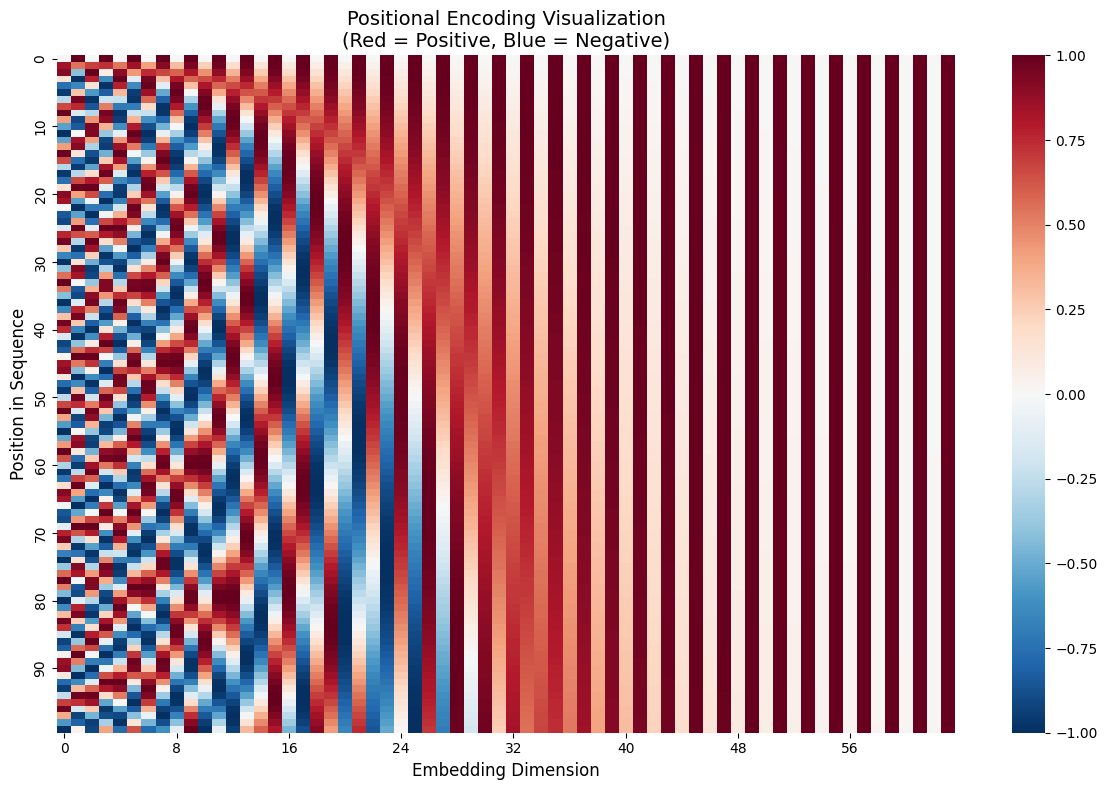

Observations:
1. Left side (low dimensions): High frequency patterns - changes rapidly with position
2. Right side (high dimensions): Low frequency patterns - changes slowly
3. Each position has a UNIQUE pattern!


In [11]:
# Create a larger positional encoding for better visualization
max_seq_len_viz = 100
d_model_viz = 64

position_viz = torch.arange(0, max_seq_len_viz, dtype=torch.float).unsqueeze(1)
div_term_viz = torch.exp(torch.arange(0, d_model_viz, 2).float() * (-np.log(10000.0) / d_model_viz))

pe_viz = torch.zeros(max_seq_len_viz, d_model_viz)
pe_viz[:, 0::2] = torch.sin(position_viz * div_term_viz)
pe_viz[:, 1::2] = torch.cos(position_viz * div_term_viz)

# Visualize as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pe_viz.numpy(), cmap='RdBu_r', center=0, 
            xticklabels=8, yticklabels=10)
plt.xlabel('Embedding Dimension', fontsize=12)
plt.ylabel('Position in Sequence', fontsize=12)
plt.title('Positional Encoding Visualization\n(Red = Positive, Blue = Negative)', fontsize=14)
plt.tight_layout()
plt.show()

print("Observations:")
print("1. Left side (low dimensions): High frequency patterns - changes rapidly with position")
print("2. Right side (high dimensions): Low frequency patterns - changes slowly")
print("3. Each position has a UNIQUE pattern!")

### **1.5 The Complete PositionalEncoding Module**

Now let's wrap everything into a proper `nn.Module`:

In [12]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding using sine and cosine functions.
    
    Adds positional information to input embeddings so the model
    can distinguish between different positions in the sequence.
    
    Args:
        d_model: Embedding dimension (must match input embedding size)
        max_seq_len: Maximum sequence length to support
        dropout: Dropout probability (default: 0.1)
    """
    
    def __init__(self, d_model, max_seq_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        # Shape: (max_seq_len, d_model)
        pe = torch.zeros(max_seq_len, d_model)
        
        # Position indices: [0, 1, 2, ..., max_seq_len-1]
        # Shape: (max_seq_len, 1)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        
        # Division term: 10000^(2i/d_model) computed as exp for stability
        # Shape: (d_model/2,)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension: (1, max_seq_len, d_model)
        pe = pe.unsqueeze(0)
        
        # Register as buffer (not a parameter, but should be saved with model)
        # Buffers are tensors that are part of the module but not trainable
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Add positional encoding to input embeddings.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            
        Returns:
            Tensor of same shape with positional encoding added
        """
        # x: (batch_size, seq_len, d_model)
        # self.pe: (1, max_seq_len, d_model)
        # We slice pe to match the actual sequence length
        seq_len = x.size(1)
        
        # Add positional encoding (broadcasts across batch dimension)
        x = x + self.pe[:, :seq_len, :]
        
        return self.dropout(x)

print("✅ PositionalEncoding class defined!")

✅ PositionalEncoding class defined!


### **1.6 Testing the PositionalEncoding Module**

In [13]:
# Now let's verify that attention can distinguish positions
print("=" * 60)
print("ATTENTION WITH POSITIONAL ENCODING")
print("=" * 60)

# Create positional encoder for d_model=4
pos_enc_small = PositionalEncoding(d_model = 4, max_seq_len = 10, dropout = 0.0)

# Add positional encodings
sentence1_with_pos = pos_enc_small(sentence1)
sentence2_with_pos = pos_enc_small(sentence2)

# Compute attention
_, weights1 = scaled_dot_product_attention(sentence1_with_pos, sentence1_with_pos, sentence1_with_pos)
_, weights2 = scaled_dot_product_attention(sentence2_with_pos, sentence2_with_pos, sentence2_with_pos)

ATTENTION WITH POSITIONAL ENCODING


In [14]:
print("\n=== 1. Labeled Attention Matrices ===")
# Use Pandas to attach word labels to the matrix
df1 = pd.DataFrame(weights1[0].detach().numpy(), index=words1, columns=words1)
df2 = pd.DataFrame(weights2[0].detach().numpy(), index=words2, columns=words2)

print("\n--- Order: Cat, Sat, Mat ---")
print(df1.round(3))

print("\n--- Order: Mat, Cat, Sat ---")
print(df2.round(3))

print("\n\n=== 2. The 'Spot Check' Proof ===")
# Extract exactly how much 'cat' focuses on 'mat' in both cases
cat_focus_mat_1 = df1.loc['cat', 'mat']
cat_focus_mat_2 = df2.loc['cat', 'mat']

print(f"Scenario 1 (Cat is #1, Mat is #3): Cat->Mat Score = {cat_focus_mat_1:.3f}")
print(f"Scenario 2 (Mat is #1, Cat is #2): Cat->Mat Score = {cat_focus_mat_2:.3f}")

print("-" * 30)
if cat_focus_mat_1 == cat_focus_mat_2:
    print("✅ PROVEN: The attention score is IDENTICAL regardless of position.")
else:
    print("❌ Failed.")


=== 1. Labeled Attention Matrices ===

--- Order: Cat, Sat, Mat ---
       cat    sat    mat
cat  0.303  0.501  0.196
sat  0.266  0.629  0.105
mat  0.237  0.239  0.524

--- Order: Mat, Cat, Sat ---
       mat    cat    sat
mat  0.350  0.321  0.329
cat  0.181  0.516  0.302
sat  0.226  0.368  0.406


=== 2. The 'Spot Check' Proof ===
Scenario 1 (Cat is #1, Mat is #3): Cat->Mat Score = 0.196
Scenario 2 (Mat is #1, Cat is #2): Cat->Mat Score = 0.181
------------------------------
❌ Failed.


---

## **Step 2: Position-wise Feed-Forward Network**

---

### **2.1 What is the Position-wise Feed-Forward Network?**

#### **The Problem: Attention is Linear!**

Remember the attention formula?

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

While softmax adds some non-linearity to the attention weights, the overall operation is mostly **linear**:
- Matrix multiplications (Q, K, V projections)
- Weighted sum of values

**Why is this a problem?**

Linear transformations have limited expressiveness:
- Multiple linear layers = equivalent to a single linear layer
- Can't learn complex, non-linear patterns
- Limited representational power

$$\text{Linear}_2(\text{Linear}_1(x)) = \text{Linear}_3(x)$$

We need **non-linearity** to learn complex functions!

#### **The Solution: Feed-Forward Network**

The Feed-Forward Network (FFN) is a simple **two-layer MLP** with a non-linear activation:

$$\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2$$


**Architecture Diagram:**

```
Input (d_model=512)
        ↓
  [Linear Layer 1]
   (512 → 2048)
        ↓
     [ReLU]
        ↓
    [Dropout]
        ↓
  [Linear Layer 2]
   (2048 → 512)
        ↓
Output (d_model=512)
```

<div align="center">
  <img src="https://lena-voita.github.io/resources/lectures/seq2seq/transformer/ffn-min.png" width="400"/>
  <p><i>A Feed-Forward Network</i></p>
</div>

### **2.2 Why "Position-wise"?**

The key insight is that the FFN is applied **independently to each position**:

<div align="center">
  <img src="https://miro.medium.com/max/1906/1*1l5JbeGfEGh2oxjI8koHdQ.png" width="700"/>
  <p><i>Position-wise Application of FFN</i></p>
</div>

```
Sequence: ["The", "cat", "sat", "on", "the", "mat"]
              ↓       ↓      ↓     ↓      ↓      ↓
            FFN     FFN    FFN   FFN    FFN    FFN
              ↓       ↓      ↓     ↓      ↓      ↓
          [out_1] [out_2] [out_3] [out_4] [out_5] [out_6]
```

**Important:** 
- Same weights for all positions (parameter sharing)
- No interaction between positions (unlike attention)
- Each position transformed independently

**Analogy:**

Think of attention as a **group discussion** where everyone talks to each other, and FFN as **individual thinking** where each person processes information on their own.

| Component | What It Does | Analogy |
|-----------|--------------|--------|
| Attention | Positions interact with each other | Group discussion 👥 |
| FFN | Each position transformed independently | Individual thinking 🧠 |

### **2.3 The Expand-Contract Pattern**

A key design choice in the FFN is the **expand-then-contract** pattern:

```
d_model (512) → d_ff (2048) → d_model (512)
     ↓              ↓              ↓
  Narrow        Expanded        Narrow
```

**Why Expand to 4× the Size?**

1. **More Expressiveness**: The larger hidden dimension allows for more complex computations
2. **Bottleneck Architecture**: Forces the model to learn compressed representations
3. **Feature Detection**: Each hidden unit can detect different patterns

**Analogy: The Thinking Process**

Imagine solving a complex problem:

1. **Input (512 dims)**: You receive information
2. **Expand (2048 dims)**: You think about many aspects, consider various possibilities
3. **Contract (512 dims)**: You summarize your thoughts into a conclusion

The expansion allows for **richer intermediate representations**!

### **2.4 Implementing the Position-wise Feed-Forward Network**

In [15]:
class PositionWiseFeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network
    
    This is a simple two-layer MLP applied independently to each position.
    
    Architecture:
        Input (d_model) → Linear → Activation → Dropout → Linear → Output (d_model)
    
    Args:
        d_model: Model dimension (e.g., 512)
        d_ff: Feed-forward hidden dimension (typically 4 * d_model = 2048)
        dropout: Dropout probability (default: 0.1)
        activation: Activation function ('relu')
    """
    
    def __init__(self, d_model, d_ff, dropout = 0.1, activation = 'relu'):
        super(PositionWiseFeedForward, self).__init__()
        
        # Store dimensions for inspection
        self.d_model = d_model
        self.d_ff = d_ff
        
        # First linear layer: expand from d_model to d_ff
        self.linear1 = nn.Linear(d_model, d_ff)
        
        # Second linear layer: contract from d_ff back to d_model
        self.linear2 = nn.Linear(d_ff, d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Activation function
        if activation == 'relu':
            self.activation = F.relu
        else:
            raise ValueError(f"Unknown activation: {activation}. Use 'relu'.")
        
        self.activation_name = activation
    
    def forward(self, x):
        """
        Forward pass of the FFN.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        
        Returns:
            Output tensor of shape (batch_size, seq_len, d_model)
        """
        # Step 1: Expand dimensions (d_model → d_ff)
        x = self.linear1(x)  # (batch, seq_len, d_ff)
        
        # Step 2: Apply activation function
        x = self.activation(x)
        
        # Step 3: Apply dropout
        x = self.dropout(x)
        
        # Step 4: Contract dimensions (d_ff → d_model)
        x = self.linear2(x)  # (batch, seq_len, d_model)
        
        return x
    
    def __repr__(self):
        return (f"PositionWiseFeedForward(\n"
                f"  d_model={self.d_model},\n"
                f"  d_ff={self.d_ff},\n"
                f"  activation={self.activation_name}\n"
                f")")

In [16]:
# Let's test our implementation!

# Configuration (matching the original Transformer paper)
d_model = 512
d_ff = 2048  # 4 * d_model
dropout = 0.1

# Create FFN with ReLU
ffn_relu = PositionWiseFeedForward(d_model, d_ff, dropout, activation='relu')
print("FFN with ReLU:")
print(ffn_relu)
print()

FFN with ReLU:
PositionWiseFeedForward(
  d_model=512,
  d_ff=2048,
  activation=relu
)



In [17]:
# Test with sample input
batch_size = 2
seq_len = 10

# Create random input
x = torch.randn(batch_size, seq_len, d_model)

print(f"Input shape: {x.shape}")
print(f"  → (batch_size={batch_size}, seq_len={seq_len}, d_model={d_model})")
print()

# Forward pass
ffn_relu.eval()  # Set to eval mode to disable dropout for testing
with torch.no_grad():
    output = ffn_relu(x)

print(f"Output shape: {output.shape}")
print(f"  → (batch_size={batch_size}, seq_len={seq_len}, d_model={d_model})")
print()
print("✅ Input and output shapes match! (as expected)")

Input shape: torch.Size([2, 10, 512])
  → (batch_size=2, seq_len=10, d_model=512)

Output shape: torch.Size([2, 10, 512])
  → (batch_size=2, seq_len=10, d_model=512)

✅ Input and output shapes match! (as expected)


---

## **Step 3: Layer Normalization**

---

### **3.1 Why Normalize?**

Neural network activations can have wildly different scales across layers and training steps. This causes:

1. **Unstable Training**: Large activations → large gradients → exploding updates
2. **Slow Convergence**: Network spends time learning to rescale values
3. **Sensitivity to Initialization**: Bad initial weights cause training to fail

**Normalization** forces activations to have consistent statistics (mean ≈ 0, std ≈ 1), which:
- Stabilizes training
- Allows higher learning rates
- Reduces sensitivity to initialization

### **3.2 Batch Norm vs Layer Norm**

<div align="center">
  <img src="https://i.sstatic.net/E3104.png" width="500"/>
  <p><i>Batch Norm vs Layer Norm</i></p>
</div>

| Aspect | Batch Normalization | Layer Normalization |
|--------|---------------------|---------------------|
| Normalizes across | Batch dimension | Feature dimension |
| Depends on | Other samples in batch | Only current sample |
| Works with small batches? | ❌ No (noisy statistics) | ✅ Yes |
| Works with variable seq lengths? | ❌ Problematic | ✅ Yes |
| Used in | CNNs (ResNet, etc.) | Transformers, RNNs |

**Why Layer Norm for Transformers?** Because sentences vary in length and we want the normalization of a specific word (token) to depend only on that word's own features, not on the other words in the sentence or other sentences in the batch.

### **3.3 Layer Normalization Formula (PyTorch: `nn.LayerNorm(d_model)`)**

For an input vector $x$ of dimension $d$:

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

Where:
- $\mu = \frac{1}{d}\sum_{i=1}^{d} x_i$ (mean across features)
- $\sigma^2 = \frac{1}{d}\sum_{i=1}^{d} (x_i - \mu)^2$ (variance across features)
- $\gamma$ = learnable scale parameter (initialized to 1)
- $\beta$ = learnable shift parameter (initialized to 0)
- $\epsilon$ = small constant for numerical stability (e.g., 1e-6)

---

## **Step 4: Residual Connections**

---

### **4.1 Residual Connections**

A simple but powerful idea: **add the input to the output**:

$$\text{output} = \text{sublayer}(x) + x$$

**Why Residual Connections?**

1. **Gradient Flow**: Provides a "highway" for gradients to flow backward
2. **Identity Mapping**: Network can easily learn to do nothing if needed
3. **Deep Networks**: Enables training of very deep models (6+ layers)

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*HRwG0yzP5z9SZu1iDSss2g.png" width="500"/>
</div>

**Without residuals:** Gradients vanish in deep networks → training fails

**With residuals:** Gradients flow freely → deep networks train successfully

---

## **Step 5: Complete Encoder Layer Architecture**

---

<table>
  <tr>
    <td style="vertical-align: top; border: none;">
<pre>
                Input (batch, seq_len, d_model)
                             |
                             ▼
                  ┌────────────────────────┐
                  │   Multi-Head Attention │
                  └────────────────────────┘
                             |
                             ▼
                    Dropout + Residual ──────────┐
                             |                   |
                             ▼                   |
                  ┌────────────────────────┐     |
                  │    Layer Normalization │◄────┘
                  └────────────────────────┘
                             |
                             ▼
                  ┌────────────────────────┐
                  │   Feed-Forward Network │
                  └────────────────────────┘
                             |
                             ▼
                    Dropout + Residual ──────────┐
                             |                   |
                             ▼                   |
                  ┌────────────────────────┐     |
                  │    Layer Normalization │◄────┘
                  └────────────────────────┘
                             |
                             ▼
                   Output (batch, seq_len, d_model)
</pre>
    </td>
    <td style="vertical-align: top; border: none; text-align: center;">
      <br><br> <img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width="300"/>
      <p><i>A single Encoder Layer</i></p>
    </td>
  </tr>
</table>

### **5.1 Implementing the Encoder**

In [18]:
# Multi-Head Attention (from Day 7)

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism.
    
    Splits the input into multiple heads, applies scaled dot-product attention
    to each head, and concatenates the results.
    
    Args:
        d_model: Model dimension (e.g., 512)
        num_heads: Number of attention heads (e.g., 8)
        dropout: Dropout probability (default: 0.1)
    """
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Compute scaled dot-product attention.
        
        Args:
            Q: Queries (batch, num_heads, seq_len, d_k)
            K: Keys (batch, num_heads, seq_len, d_k)
            V: Values (batch, num_heads, seq_len, d_k)
            mask: Optional mask (batch, 1, 1, seq_len) or (batch, 1, seq_len, seq_len)
        
        Returns:
            output: Attention output (batch, num_heads, seq_len, d_k)
            attention_weights: Attention weights (batch, num_heads, seq_len, seq_len)
        """
        d_k = Q.size(-1)
        
        # Compute attention scores: Q @ K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
        
        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        """
        Forward pass of Multi-Head Attention.
        
        Args:
            query: Query tensor (batch, seq_len, d_model)
            key: Key tensor (batch, seq_len, d_model)
            value: Value tensor (batch, seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            output: Attention output (batch, seq_len, d_model)
            attention_weights: Attention weights (batch, num_heads, seq_len, seq_len)
        """
        batch_size = query.size(0)
        
        # Linear projections
        Q = self.W_q(query)  # (batch, seq_len, d_model)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Reshape for multi-head: (batch, seq_len, d_model) -> (batch, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        attn_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads: (batch, num_heads, seq_len, d_k) -> (batch, seq_len, d_model)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # Final linear projection
        output = self.W_o(attn_output)
        
        return output, attention_weights

print("✅ MultiHeadAttention class defined!")

✅ MultiHeadAttention class defined!


In [19]:
class EncoderLayer(nn.Module):
    """
    A single Encoder Layer of the Transformer.
    
    Consists of:
    1. Multi-Head Self-Attention with residual connection and layer norm
    2. Position-wise Feed-Forward Network with residual connection and layer norm
    
    Args:
        d_model: Model dimension (e.g., 512)
        num_heads: Number of attention heads (e.g., 8)
        d_ff: Feed-forward hidden dimension (e.g., 2048)
        dropout: Dropout probability (default: 0.1)
        activation: Activation function for FFN ('relu' or 'gelu')
    """
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, activation='relu'):
        super(EncoderLayer, self).__init__()
        
        # Multi-Head Self-Attention
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        
        # Position-wise Feed-Forward Network
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout, activation)
        
        # Layer Normalization (one for each sublayer)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout (for residual connections)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Forward pass of the Encoder Layer.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            output: Encoded output of shape (batch_size, seq_len, d_model)
            attention_weights: Self-attention weights (batch, num_heads, seq_len, seq_len)
        """
        # ============================================
        # Sublayer 1: Multi-Head Self-Attention
        # ============================================
        
        # Self-attention (Q = K = V = x)
        attn_output, attention_weights = self.self_attention(x, x, x, mask)
        
        # Dropout
        attn_output = self.dropout1(attn_output)
        
        # Residual connection + Layer Normalization (Post-Norm)
        x = self.norm1(x + attn_output)
        
        # ============================================
        # Sublayer 2: Position-wise Feed-Forward
        # ============================================
        
        # Feed-forward network
        ff_output = self.feed_forward(x)
        
        # Dropout
        ff_output = self.dropout2(ff_output)
        
        # Residual connection + Layer Normalization (Post-Norm)
        output = self.norm2(x + ff_output)
        
        return output, attention_weights

print("✅ EncoderLayer class defined!")
print()
print("Architecture summary:")
print("  Input → Self-Attention → Add & Norm → FFN → Add & Norm → Output")

✅ EncoderLayer class defined!

Architecture summary:
  Input → Self-Attention → Add & Norm → FFN → Add & Norm → Output


### **5.2 Testing the Encoder Layer**

In [20]:
# Test the Encoder Layer with the original Transformer configuration

# Configuration (from "Attention Is All You Need" paper)
d_model = 512
num_heads = 8
d_ff = 2048
dropout = 0.1

# Create the encoder layer
encoder_layer = EncoderLayer(
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    dropout=dropout,
    activation='relu'
)

print("Encoder Layer Configuration:")
print(f"  d_model: {d_model}")
print(f"  num_heads: {num_heads}")
print(f"  d_ff: {d_ff}")
print(f"  dropout: {dropout}")
print()

# Create sample input
batch_size = 2
seq_len = 10

x = torch.randn(batch_size, seq_len, d_model)

print(f"Input shape: {x.shape}")
print(f"  → (batch_size={batch_size}, seq_len={seq_len}, d_model={d_model})")

# Forward pass
encoder_layer.eval()
with torch.no_grad():
    output, attention_weights = encoder_layer(x)

print(f"\nOutput shape: {output.shape}")
print(f"  → (batch_size={batch_size}, seq_len={seq_len}, d_model={d_model})")
print(f"\nAttention weights shape: {attention_weights.shape}")
print(f"  → (batch_size={batch_size}, num_heads={num_heads}, seq_len={seq_len}, seq_len={seq_len})")
print()
print("✅ Encoder Layer works correctly!")

Encoder Layer Configuration:
  d_model: 512
  num_heads: 8
  d_ff: 2048
  dropout: 0.1

Input shape: torch.Size([2, 10, 512])
  → (batch_size=2, seq_len=10, d_model=512)

Output shape: torch.Size([2, 10, 512])
  → (batch_size=2, seq_len=10, d_model=512)

Attention weights shape: torch.Size([2, 8, 10, 10])
  → (batch_size=2, num_heads=8, seq_len=10, seq_len=10)

✅ Encoder Layer works correctly!


### **5.3 Real sentence — feed through encoder and visualize self-attention**

Let's pass a real sentence through an EncoderLayer and visualize the attention matrices for each head and the average across heads.

In [ ]:
# # Real-sentence self-attention visualization demo
# sentence = "The quick brown fox jumps over the lazy dog".lower().split()
# tokens = sentence

# # Build a small vocab (easy demo)
# vocab = sorted(set(tokens))
# vocab_to_idx = {w:i for i,w in enumerate(vocab)}

# # Simple embedding layer and inputs
# d_model = 64  # small for visualization
# num_heads = 8
# d_ff = d_model * 4

# embed = nn.Embedding(len(vocab), d_model)
# ids = torch.tensor([[vocab_to_idx[t] for t in tokens]])  # shape: (1, seq_len)
# x = embed(ids)  # (1, seq_len, d_model)

# # Positional encoding (reuse class defined earlier)
# pos_enc = PositionalEncoding(d_model=d_model, max_seq_len=len(tokens), dropout=0.0)
# x_pos = pos_enc(x)

# # Encoder layer (small) and forward pass
# encoder_layer_viz = EncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=0.0, activation='relu')
# encoder_layer_viz.eval()
# with torch.no_grad():
#     encoder_out, attn_weights = encoder_layer_viz(x_pos)  # attn_weights: (batch, num_heads, seq_len, seq_len)

# attn = attn_weights[0].detach().numpy()  # (num_heads, seq_len, seq_len)
# seq_len = len(tokens)

# # Plot each head
# import math
# ncols = 4
# nrows = math.ceil(num_heads / ncols)
# plt.figure(figsize=(4*ncols, 3*nrows))
# for i in range(num_heads):
#     plt.subplot(nrows, ncols, i+1)
#     sns.heatmap(attn[i], xticklabels=tokens, yticklabels=tokens, cmap='viridis', cbar=False)
#     plt.title(f'Head {i}')
#     plt.xticks(rotation=45, ha='right')
#     plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# # Plot average across heads
# avg_attn = attn.mean(axis=0)
# plt.figure(figsize=(8, 6))
# sns.heatmap(avg_attn, xticklabels=tokens, yticklabels=tokens, cmap='viridis', annot=False)
# plt.title('Average Attention across heads')
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.show()

# print('Tokens:', tokens)
# print('Encoder output shape:', encoder_out.shape)

#### **Where do keys & values for decoder cross-attention come from?**

The decoder's cross-attention uses the encoder's outputs as Keys and Values. The decoder provides Queries (coming from its own previous self-attention layer / decoder inputs).

So the encoder produces a sequence of encoded vectors (one per token) — those are projected to K and V inside the MultiHeadAttention used in the decoder's cross-attention.

In [ ]:
# # Quick demo: cross-attention where encoder outputs are used as K and V
# # Use the same encoder_out from previous cell as keys & values

# # Create a decoder 'query' token (e.g., the token 'fox')
# query_token = 'fox'
# query_idx = torch.tensor([[vocab_to_idx[query_token]]])
# q_embed = embed(query_idx)                 # (1, 1, d_model)
# q_pos = pos_enc(q_embed)                   # add positional info (optional here)

# # MultiHeadAttention instance (same dims)
# mha_cross = MultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=0.0)
# mha_cross.eval()

# with torch.no_grad():
#     # Query = decoder query; Key = Value = encoder_out
#     out_cross, cross_attn = mha_cross(q_pos, encoder_out, encoder_out)

# print('Cross-attention weights shape:', cross_attn.shape)  # (batch, num_heads, q_len=1, k_len=seq_len)

# # Visualize cross-attention for each head (query length is 1 so we plot k_len along x axis)
# cross = cross_attn[0].detach().numpy()  # (num_heads, 1, seq_len)
# plt.figure(figsize=(12, 6))
# for i in range(num_heads):
#     plt.subplot(2, 4, i+1)
#     sns.heatmap(cross[i].squeeze(0)[None, :], xticklabels=tokens, yticklabels=[f'Query:{query_token}'], cmap='magma', cbar=False)
#     plt.title(f'Head {i}')
#     plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# print('Cross-attention (averaged across heads):\n', cross.mean(axis=0).squeeze(0))

In [ ]:
# Load pretrained model
pretrained = BertModel.from_pretrained('bert-base-uncased')

# Copy weights to your EncoderLayer
your_encoder = EncoderLayer(d_model=768, num_heads=12, d_ff=3072)

# Copy attention weights
your_encoder.self_attention.load_state_dict(
    pretrained.encoder.layer[0].attention.state_dict()
)

# Copy FFN weights
your_encoder.feed_forward.load_state_dict(
    pretrained.encoder.layer[0].intermediate.state_dict()
)

In [ ]:
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Everything matches perfectly
text = "The cat sat on the mat"
inputs = tokenizer(text, return_tensors='pt')
embeddings = model.embeddings(inputs['input_ids'])  # (batch, seq, 768)
encoder_output = model.encoder.layer[0](embeddings)  # Works!